# Introduction
Genetic algorithms work by iterating over generations of populations and evaluation how well these populations solve a problem. At the end of a generation, the best individuals are selected to produce the next generation. 

The code presented in this blog has been adapted from:


**Zaccone G. (2019). Natural Computing with Python: Learn to implement genetic and evolutionary algorithms for problem solving in a pythonic way. BPB Publications.**



# Imports
First we import all necessary modules.

In [1]:
import random
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
EPS = 0.0001  # Numerical value for zero

# Data Representation
Because we are going to work with the simplest form of the TSP, we need a way to represent the data:

In [3]:
class City:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.name) + ")"


# How the algorithm works?

## The concept of individual
An individual can be seen as a single instance of the problem, for this case it's easy to see that the individual is the sequence of "cities" and the order that they are visited.

## Fitness
Genetic algorithms mimic natural structures using the idea of "Survival of the fittest", so it's important to define a common fitness function for all individuals. For this case, the fitness of an individual is the sum of the distance for each pair of consecutive cities, including the sum of the last city in the sequence and the first (because TSP forms a loop).
>$Fitness=[\sum_{i=1}^{N-1} Distance(City_{i},City_{i+1})]+Distance(City_{N},City_{1})$

This "Distance" function is just the euclidian distance between each city.

In [8]:
class Route:
    def __init__(self, route):
        self.route = route  # Sequence of cities (1st node is the origin)
        self.distance = 0.0
        self.fitness = 0.0

    def get_distance(self):
        """
        Check if the distance variable has already been calculated for this route.
        If not (i.e., distance is 0), calculate it.
        """
        if self.distance > EPS:
            return self.distance

        self.distance = 0.0
        for idx, from_ in enumerate(self.route[:-1]):
            self.distance += from_.distance(self.route[idx + 1])

        # Back to origin
        self.distance += self.route[-1].distance(self.route[0])
        return self.distance

    def get_fitness(self):
        if self.fitness <= EPS:
            self.fitness = 1.0 / float(self.get_distance())
        return self.fitness

## Mutation and Breeding
The algorithm creates the next generations using two methods, either mutating single individuals based on a probability, or "mating" two individual to create a new one. Here we define all necesarry functions to perform the algorithm.

In [9]:
def create_route(cities):
    """Get a random permutation of the cities."""
    return random.sample(cities, len(cities))


def initial_population(pop_size, cities):
    """Creates a random population of the specified size."""
    return [create_route(cities) for _ in range(pop_size)]


def rank_routes(population):
    """Order the population by fitness descending."""
    fitnessResults = {}
    for i in range(len(population)):
        fitnessResults[i] = Route(population[i]).get_fitness()
    sorted_results = sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_results


#Create a selection function that will be used to make the list of parent routes
def selection(popRanked, eliteSize):
    selectionResults = []  # Create an empty list to store selected individuals
    df = pd.DataFrame(np.array(popRanked), columns=["Index",
                                                    "Fitness"])  # Convert the population to a pandas dataframe with two columns - index and
    # fitness
    df['cum_sum'] = df.Fitness.cumsum()  # Add a new column called cum_sum, which is the cumulative sum of fitness
    df[
        'cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()  # Add another new column called cum_perc, which is the percentage of the total fitness that each
    # individual represents

    for i in range(0,
                   eliteSize):  # Select the elite individuals (top performers) and add their indices to selectionResults
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):  # Select the remaining individuals using roulette wheel selection
        pick = 100 * random.random()  # Generate a random number between 0 and 100
        for i in range(0, len(popRanked)):
            if pick <= df.iat[
                i, 3]:  # If the random number is less than or equal to the cumulative percentage of an individual's fitness, select that
                # individual
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults  # Return the list of selected individuals
    # selectionResults is a list of indices that represent the selected individuals in the population based on their fitness.


#Create mating pool
def mating_pool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool  # returns the list of selected individuals.


#Create a crossover function for two parents to create one child
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]
    #print(startGene, endGene)

    #print(parent1)
    #print(parent2)

    #print(childP1)
    #print(childP2)
    child = childP1 + childP2

    #print(child)
    return child


'''
1. breed(parent1, parent2) - This is the function signature that takes in two parent individuals to create a new child individual.
2. child = [] - This initializes an empty list to hold the child individual.
3. childP1 = [] and childP2 = [] - These are the two halves of the child individual that are created by combining the genes of the two parents.
4. geneA = int(random.random() * len(parent1)) and geneB = int(random.random() * len(parent1)) - These lines generate two random integers between 0 and 
the length of the parent individual minus 1.
5. startGene = min(geneA, geneB) and endGene = max(geneA, geneB) - These lines determine the start and end positions of the gene segment to be inherited 
from one parent. The smaller of the two random integers is used as the starting position and the larger is used as the ending position.
6. for i in range(startGene, endGene): childP1.append(parent1[i]) - This loop copies the selected gene segment from the first parent and adds it to 
childP1.
7. childP2 = [item for item in parent2 if item not in childP1] - This line creates childP2 by copying the remaining genes from the second parent that were 
not already included in childP1.
8. child = childP1 + childP2 - This line concatenates childP1 and childP2 to form the complete child individual.
9. return child - This line returns the child individual created by combining the genes of the two parents.
'''


# Create function to run crossover over full mating pool
def breed_population(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0, eliteSize):
        children.append(matingpool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool) - i - 1])
        children.append(child)
    return children


'''
1. The breedPopulation() method takes in two parameters: matingpool and eliteSize.
2. The method initializes an empty list called children.
3. It calculates the length of the mating pool minus the elite size and stores the result in the variable length.
4. The method creates a new list called pool by randomly sampling from the matingpool list using the random.sample() method. This creates a new list 
of the same size as matingpool, but with the order of elements randomized.
5. The method adds the eliteSize best individuals from the matingpool list to the children list. These individuals were selected based on their fitness 
rank, as determined by the rankRoutes() method.
6. The method then enters a loop that will generate the rest of the children in the children list. The loop runs for length iterations, which is the 
number of children needed to fill out the population size.
7. The method creates a new child by calling the breed() method with two parents randomly chosen from the pool list.
8. The child is added to the children list.
9. Finally, the children list is returned, containing the new population of individuals created by breeding the parents in the matingpool list.
'''


#Create function to mutate a single route
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if random.random() < mutationRate:
            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
    return individual


'''
1. def mutate(individual, mutationRate): defines the mutate() function with two parameters:
    individual: a list representing a single route
    mutationRate: the probability of any given gene in the route being mutated
2. for swapped in range(len(individual)): swapped iterates through each index of the route.
3. if(random.random() < mutationRate): With probability mutationRate, the genes at the current index will be mutated.
4. swapWith = int(random.random() * len(individual)) Generates a random index to swap with the current index.
5. city1 = individual[swapped] and city2 = individual[swapWith] Save the original values of the two genes being swapped for reference.
6. individual[swapped] = city2 and individual[swapWith] = city1 Swap the values of the two genes.
7. return individual Return the mutated route.
'''


#Create function to run mutation over entire population
def mutate_population(population, mutationRate):
    """
    1. The mutatePopulation() function takes in two arguments: population and mutationRate. The population argument is a list of individuals, where each
    individual is represented as a list of cities (i.e., a route). The mutationRate argument is a probability that determines the likelihood that a
    mutation will occur in an individual. The function initializes an empty list called mutatedPop to store the mutated individuals.
    2. The function iterates over each individual in the population list, and for each individual, it calls the mutate() method (which we explained earlier)
    with the individual and mutationRate arguments. The mutate() method mutates the individual with the specified probability and returns the mutated
    individual. The function then adds the mutated individual to the mutatedPop list. After iterating over all individuals in the population list, the
    function returns the mutatedPop list containing all the mutated individuals.

    In summary, the mutatePopulation() method applies the mutate() method to each individual in the population with a specified mutation rate, and returns
    a new population containing the mutated individuals. This process helps to introduce genetic diversity into the population, which is essential for the
    genetic algorithm to explore different parts of the search space.
"""

    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop


def next_generation(current_generation, elite_size, mutation_rate):
    """Create a new population from the current one."""
    ret = rank_routes(current_generation)
    ret = selection(ret, elite_size)
    ret = mating_pool(current_generation, ret)
    ret = breed_population(ret, elite_size)
    return mutate_population(ret, mutation_rate)


'''
1. def nextGeneration(currentGen, eliteSize, mutationRate):: This is the function definition, which takes three arguments:
    currentGen: The current generation or population of routes.
    eliteSize: The size of the elite population, which are the fittest routes that will pass unchanged to the next generation.
    mutationRate: The probability that a given individual will undergo mutation.
2. popRanked = rankRoutes(currentGen): This line ranks the individuals in the current generation by their fitness values and returns a list of tuples 
with the index and fitness of each individual. popRanked is the result of calling the rankRoutes() function with currentGen as its argument.
3. selectionResults = selection(popRanked, eliteSize): This line calls the selection() function with popRanked and eliteSize as arguments to create a 
list of the indices of the routes that will be included in the mating pool.
4. matingpool = matingPool(currentGen, selectionResults): This line calls the matingPool() function with currentGen and selectionResults as arguments 
to create a list of the routes that will be used to create the children in the next generation.
5. children = breedPopulation(matingpool, eliteSize): This line calls the breedPopulation() function with matingpool and eliteSize as arguments to 
create a list of children that will replace the routes that were not selected to be part of the elite population in the current generation.
6. nextGeneration = mutatePopulation(children, mutationRate): This line calls the mutatePopulation() function with children and mutationRate as 
arguments to apply mutation to the children and create the next generation.
7. return nextGeneration: This line returns the next generation of routes, which will be used as the current generation in the next iteration of the 
genetic algorithm.
'''

'\n1. def nextGeneration(currentGen, eliteSize, mutationRate):: This is the function definition, which takes three arguments:\n    currentGen: The current generation or population of routes.\n    eliteSize: The size of the elite population, which are the fittest routes that will pass unchanged to the next generation.\n    mutationRate: The probability that a given individual will undergo mutation.\n2. popRanked = rankRoutes(currentGen): This line ranks the individuals in the current generation by their fitness values and returns a list of tuples \nwith the index and fitness of each individual. popRanked is the result of calling the rankRoutes() function with currentGen as its argument.\n3. selectionResults = selection(popRanked, eliteSize): This line calls the selection() function with popRanked and eliteSize as arguments to create a \nlist of the indices of the routes that will be included in the mating pool.\n4. matingpool = matingPool(currentGen, selectionResults): This line calls t

## The genetic algorithm
With all these function defined, all that is left is to write the definition of the genetic algorithm.

In [10]:
def genetic_algorithm(cities, pop_size, elite_size, mutation_rate, generations):
    # Create initial population
    pop = initial_population(pop_size, cities)

    # Create list to track convergence and add the inverse of best known solution to it
    progress = [1 / rank_routes(pop)[0][1]]
    #print("Initial distance: " + str(progress[0])) # This line prints out the initial best fitness value.

    # Run GA for the given number of iterations.
    for i in range(generations):
        if i % 50 == 0:
            print(f'Generation {i}, distance: {progress[i]})')

        # Generate next generation
        pop = next_generation(pop, elite_size, mutation_rate)

        # Track inverse of best know fitness value
        progress.append(1 / rank_routes(pop)[0][1])

    # Process results
    bestRouteIndex = rank_routes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Best Fitness vs Generation')
    plt.tight_layout()
    plt.show()

    return bestRoute  # This line returns the best route found by the genetic algorithm.

## Testing
Know we create a list of cities and run the algorithm, this should return the best route found in the last generation.

Generation 0, distance: 3794.919051433388)
Generation 50, distance: 2250.580905421483)
Generation 100, distance: 2019.3185723742558)
Generation 150, distance: 2132.2612840024376)
Generation 200, distance: 2037.3239675120155)
Generation 250, distance: 1894.7734391046376)
Generation 300, distance: 1852.0985938268086)
Generation 350, distance: 1856.0498364793941)
Generation 400, distance: 1860.0523985861807)
Generation 450, distance: 1860.0523985861807)
Generation 500, distance: 1860.0523985861807)
Generation 550, distance: 1846.916305950159)
Generation 600, distance: 1860.0523985861807)
Generation 650, distance: 1846.9163059501593)
Generation 700, distance: 1860.0523985861807)
Generation 750, distance: 1860.0523985861807)


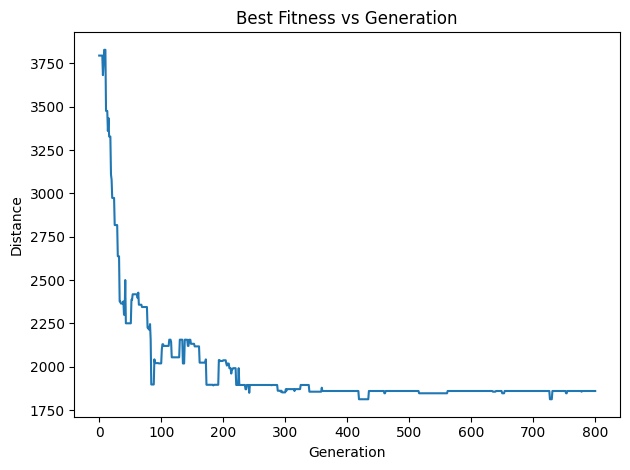

CPU times: user 4.33 s, sys: 69.4 ms, total: 4.4 s
Wall time: 4.26 s


In [11]:
%%time

# Create random cities
city_list = [City(name=i, x=int(random.random() * 400), y=int(random.random() * 400)) for i in range(0, 21)]

# Run GA
best_route = genetic_algorithm(cities=city_list, pop_size=40, elite_size=20, mutation_rate=0.01, generations=800)


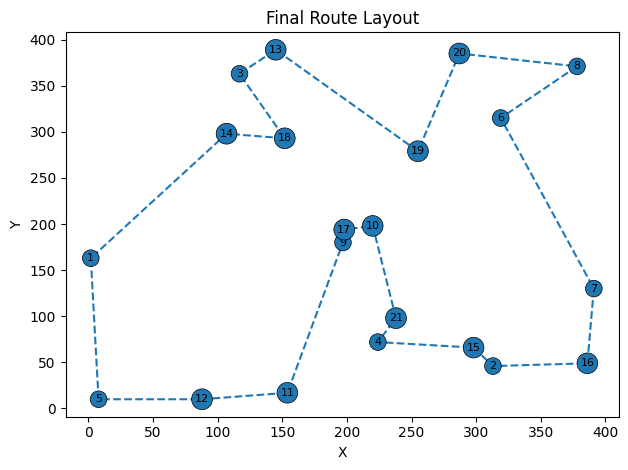

'\n1. cityList = [] - create an empty list called cityList to store the City objects.\n2. for i in range(0,5): - loop through a range of 0 to 4.\n3. cityList.append(City(name = i, x=int(random.random() * 200), y=int(random.random() * 200))) - create a new City object with a randomly generated x\nand y coordinates and append it to the cityList.\n4. best_route=geneticAlgorithm(population=cityList, popSize=30, eliteSize=20, mutationRate=0.01, generations=1) - call the geneticAlgorithm function with\nthe cityList as the population, a population size of 30, elite size of 20, mutation rate of 0.01 and 1 generation.\n5. x=[] and y=[] - create empty lists to store the x and y coordinates of the best route.\n6. for i in best_route: x.append(i.x) and for i in best_route: y.append(i.y) - loop through the City objects in the best_route and append their x and y\ncoordinates to the x and y lists.\n7. x.append(best_route[0].x) and y.append(best_route[0].y) - append the x and y coordinates of the firs

In [13]:
# Display result

x = []
y = []
for i in best_route:
    x.append(i.x)
    y.append(i.y)
x.append(best_route[0].x)
y.append(best_route[0].y)
plt.plot(x, y, '--o')
plt.xlabel('X')
plt.ylabel('Y')
ax = plt.gca()
plt.title('Final Route Layout')
bbox_props = dict(boxstyle="circle,pad=0.3", fc='C0', ec="black", lw=0.5)
for i in range(1, len(city_list) + 1):
    ax.text(city_list[i - 1].x, city_list[i - 1].y, str(i), ha="center", va="center",
            size=8,
            bbox=bbox_props)
plt.tight_layout()
plt.show()
'''
1. cityList = [] - create an empty list called cityList to store the City objects.
2. for i in range(0,5): - loop through a range of 0 to 4.
3. cityList.append(City(name = i, x=int(random.random() * 200), y=int(random.random() * 200))) - create a new City object with a randomly generated x
and y coordinates and append it to the cityList.
4. best_route=geneticAlgorithm(population=cityList, popSize=30, eliteSize=20, mutationRate=0.01, generations=1) - call the geneticAlgorithm function with
the cityList as the population, a population size of 30, elite size of 20, mutation rate of 0.01 and 1 generation.
5. x=[] and y=[] - create empty lists to store the x and y coordinates of the best route.
6. for i in best_route: x.append(i.x) and for i in best_route: y.append(i.y) - loop through the City objects in the best_route and append their x and y
coordinates to the x and y lists.
7. x.append(best_route[0].x) and y.append(best_route[0].y) - append the x and y coordinates of the first city in the best_route to the x and y lists to
complete the circuit.
8. plt.plot(x, y, '--o') - plot the x and y coordinates of the best_route as a dashed line with dots.
9. plt.xlabel('X') and plt.ylabel('Y') - set the labels for the x and y axis.
10. ax=plt.gca() - get the current axis of the plot.
11. plt.title('Final Route Layout') - set the title of the plot.
12. bbox_props = dict(boxstyle="circle,pad=0.3", fc='C0', ec="black", lw=0.5) - create a dictionary containing the properties of the text box that will
be used to label the cities.
13. for i in range(1,len(cityList)+1): - loop through a range of 1 to the length of cityList.
14. ax.text(cityList[i-1].x, cityList[i-1].y, str(i), ha="center", va="center",size=8,bbox=bbox_props) - add a text box containing the number of the city
at the x and y coordinates of the City object in cityList.
15. plt.tight_layout() - adjust the padding of the plot to ensure all elements are visible.
16. plt.show() - display the plot on the screen.
'''